In [ ]:
import os # For file manipulation
import torch # Machine learning library
import matplotlib.pyplot as plt # For graphing
import numpy as np # For math library and matrices
from sklearn.metrics import classification_report
from google.colab import drive # For accessing Google Drive
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import random
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
print(torch.cuda.is_available()) # See if cuda GPU is accessible

True


In [ ]:
drive.mount('/content/drive') # Mounting Google Drive

# Copy dataset from Google Drive to Colab's local storage (if not too large)
!cp -r /content/drive/MyDrive/COMP432Project/Dataset2/ /content/dataset2/

drive_path_dataset_2 = '/content/dataset2/' #JPG files

!cp -r /content/drive/MyDrive/COMP432Project/Dataset3 /content/dataset3/

drive_path_dataset_3 = '/content/dataset3/' #JPG files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load in our trained model from Google Drive
my_model = models.resnet18(weights=None)
model_path = '/content/drive/MyDrive/COMP432Project/resnet18_model_V1.pth'
my_model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
my_model.eval()

<ipython-input-41-c2d37205f0f2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load in a pre-trained ResNet18 model on the Imagenet dataset
pretrained_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
# Remove the fully-connected layer (head) from both models
my_model = torch.nn.Sequential(*list(my_model.children())[:-1])
pretrained_model = torch.nn.Sequential(*list(pretrained_model.children())[:-1])

In [ ]:
# Setting the seeds to ensure the same results
seed = 42
torch.manual_seed(seed)        # PyTorch seed for CPU
torch.cuda.manual_seed(seed)   # PyTorch seed for current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multiple)
np.random.seed(seed)           # NumPy seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [ ]:
def create_image_path_array(image_directory):
  # Empty list for all our processed images
  image_paths = []

  # Traverse the directory and subdirectories to find all .tif files
  for root, dirs, files in os.walk(image_directory):
      for filename in files:
          if filename.endswith(".jpg"):
              # Get full image path
              image_path = os.path.join(root, filename)
              image_paths.append(image_path)


  return image_paths

In [ ]:
  # Get the paths of all images to allow for splitting into train and test and random shuffling
  gland_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset2/Prostate Cancer/gland')
  nongland_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset2/Prostate Cancer/nongland')
  tumor_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset2/Prostate Cancer/tumor')

  # Create output labels for our images
  gland_labels = [0] * len(gland_paths)
  nongland_labels = [1] * len(nongland_paths)
  tumor_labels = [2] * len(tumor_paths)

  # Combine all paths and labels into one list
  all_paths_dataset2 = gland_paths + nongland_paths + tumor_paths
  all_labels_dataset2 = gland_labels + nongland_labels + tumor_labels

  # Shuffle our training data
  all_paths_dataset2, all_labels_dataset2 = shuffle(all_paths_dataset2, all_labels_dataset2, random_state=seed)

  # Split our dataset into train and test sets
  X_train_dataset2, X_test_dataset2, y_train_dataset2, y_test_dataset2 = train_test_split(all_paths_dataset2, all_labels_dataset2, test_size=0.2, random_state=seed)

  # Split our train dataset into train and cross-validate sets
  X_train_dataset2, X_cross_dataset2, y_train_dataset2, y_cross_dataset2 = train_test_split(X_train_dataset2, y_train_dataset2, test_size=0.2, random_state=seed)

In [ ]:
  # Get the paths of all images to allow for splitting into train and test and random shuffling
  cat_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset3/Animal Faces/cat')
  dog_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset3/Animal Faces/dog')
  wild_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Dataset3/Animal Faces/wild')

  # Create output labels for our images
  cat_labels = [0] * len(cat_paths)
  dog_labels = [1] * len(dog_paths)
  wild_labels = [2] * len(wild_paths)

  # Combine all paths and labels into one list
  all_paths_dataset3 = cat_paths + dog_paths + wild_paths
  all_labels_dataset3 = cat_labels + dog_labels + wild_labels

  # Shuffle our training data
  all_paths_dataset3, all_labels_dataset3 = shuffle(all_paths_dataset3, all_labels_dataset3, random_state=seed)

  # Split our dataset into train and test sets
  X_train_dataset3, X_test_dataset3, y_train_dataset3, y_test_dataset3 = train_test_split(all_paths_dataset3, all_labels_dataset3, test_size=0.2, random_state=seed)

  # Split our train dataset into train and cross-validate sets
  X_train_dataset3, X_cross_dataset3, y_train_dataset3, y_cross_dataset3 = train_test_split(X_train_dataset3, y_train_dataset3, test_size=0.2, random_state=seed)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image
        image = Image.open(self.image_paths[index]).convert('RGB')

        # Apply our 'preprocess' transformations (i.e. resizing, normalization)
        if self.transform:
            image = self.transform(image)

        # Get the respective label
        label = self.labels[index]

        return image, label

# Preprocessing transformations for ResNet input
preprocess = transforms.Compose([
  transforms.Resize(256),               # Resize to 256 pixels on shorter side
  transforms.CenterCrop(224),           # Crop center to 224x224
  transforms.ToTensor(),                # Convert to PyTorch tensor
  transforms.Normalize(                 # Normalize using ImageNet mean and std
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  ),
])

# Create datasets for Dataset 2
train_dataset2 = ImageDataset(X_train_dataset2, y_train_dataset2, transform=preprocess)
cross_dataset2 = ImageDataset(X_cross_dataset2, y_cross_dataset2, transform=preprocess)
test_dataset2 = ImageDataset(X_test_dataset2, y_test_dataset2, transform=preprocess)

all_dataset2 = ImageDataset(all_paths_dataset2, all_labels_dataset2, transform=preprocess)

# Create datasets for Dataset 3
train_dataset3 = ImageDataset(X_train_dataset3, y_train_dataset3, transform=preprocess)
cross_dataset3 = ImageDataset(X_cross_dataset3, y_cross_dataset3, transform=preprocess)
test_dataset3 = ImageDataset(X_test_dataset3, y_test_dataset3, transform=preprocess)

all_dataset3 = ImageDataset(all_paths_dataset3, all_labels_dataset3, transform=preprocess)

In [ ]:
# Hyperparameters
batch_size = 128

# DataLoader for dataset 2; below loaders are for SVM training
train_loader_dataset2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
cross_loader_dataset2 = DataLoader(cross_dataset2, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)
test_loader_dataset2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

# This loader is for feature extraction on Dataset 2
all_loader_dataset2 = DataLoader(all_dataset2, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

# DataLoader for dataset 3; below loaders are for SVM training
train_loader_dataset3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
cross_loader_dataset3 = DataLoader(cross_dataset3, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)
test_loader_dataset3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

# This loader is for feature extraction on Dataset 3
all_loader_dataset3 = DataLoader(all_dataset3, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

In [ ]:
def collect_features_and_targets(loader, encoder_model):
    encoder_model.eval()  # Set the encoder to evaluation mode
    all_features = []
    all_targets = []

    with torch.no_grad():  # No need for gradients during evaluation
        for batch_features, batch_targets in loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                batch_features = batch_features.to('cuda')
                batch_targets = batch_targets.to('cuda')

            # Forward pass through encoder model to get features
            features = encoder_model(batch_features)  # Shape: [batch_size, 512, 1, 1]
            features = features.view(features.size(0), -1)  # Flatten to [batch_size, 512]

            # Store features and targets
            all_features.extend(features.cpu().numpy())  # Move to CPU and convert to NumPy
            all_targets.extend(batch_targets.cpu().numpy())

    return np.array(all_features), np.array(all_targets)

In [ ]:
def tsne_visualization(features, labels, n_components=2, perplexity=30, learning_rate=200, max_iter=1000):
    # Convert lists to numpy arrays if they aren't already
    features = np.array(features)
    labels = np.array(labels)

    # Print shape information for debugging
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    # Make sure perplexity is less than n_samples
    perplexity = min(perplexity, features.shape[0] - 1)

    # Perform t-SNE
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=max_iter)
    tsne_results = tsne.fit_transform(features)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Label')
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of Data")
    plt.show()

t-SNE Visualization for Our Model Dataset 2:
Features shape: (6000, 512)
Labels shape: (6000,)


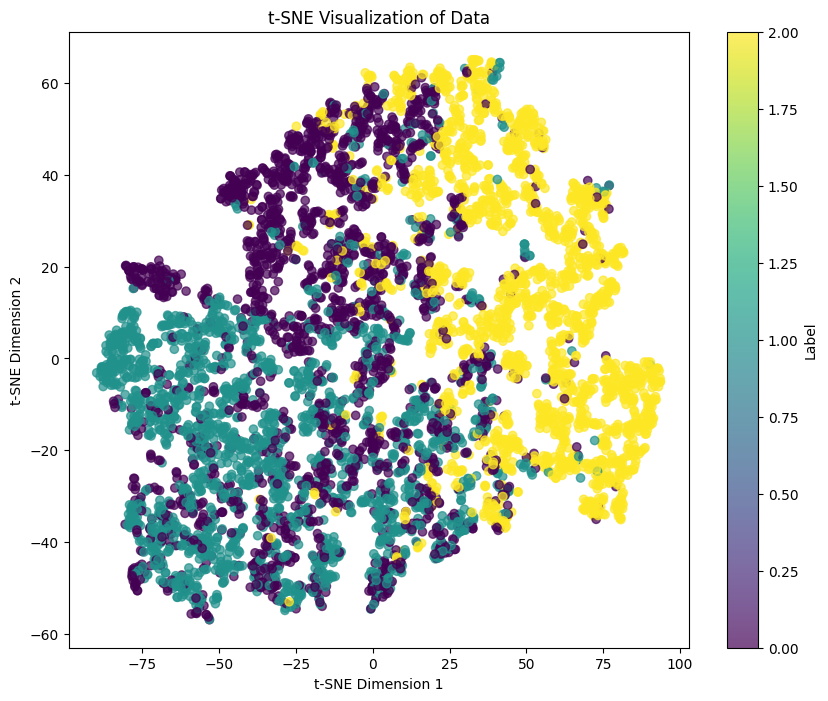

t-SNE Visualization for Pre-trained Model Dataset 2:
Features shape: (6000, 512)
Labels shape: (6000,)


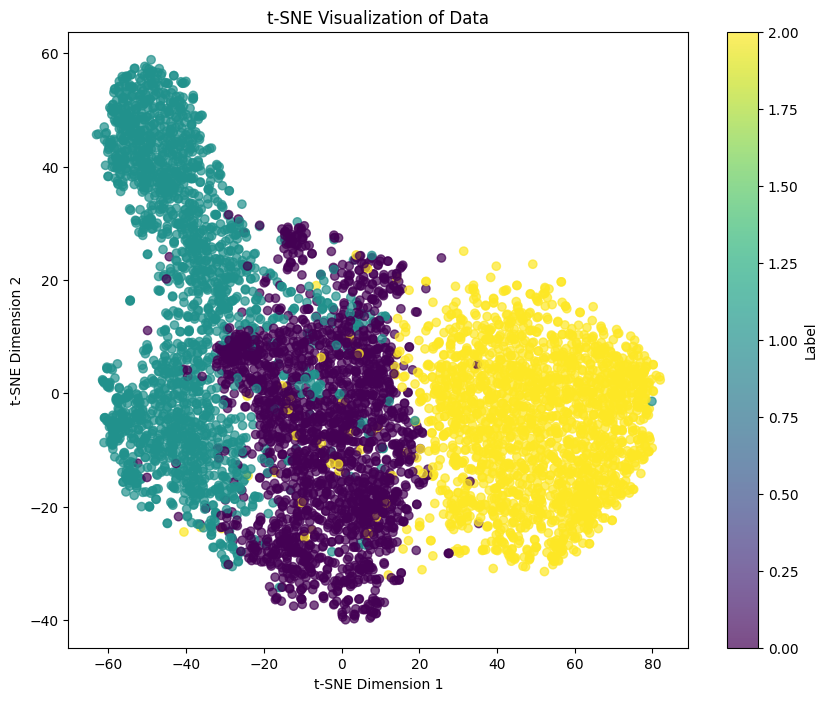

t-SNE Visualization for Our Model Dataset 3:
Features shape: (6010, 512)
Labels shape: (6010,)


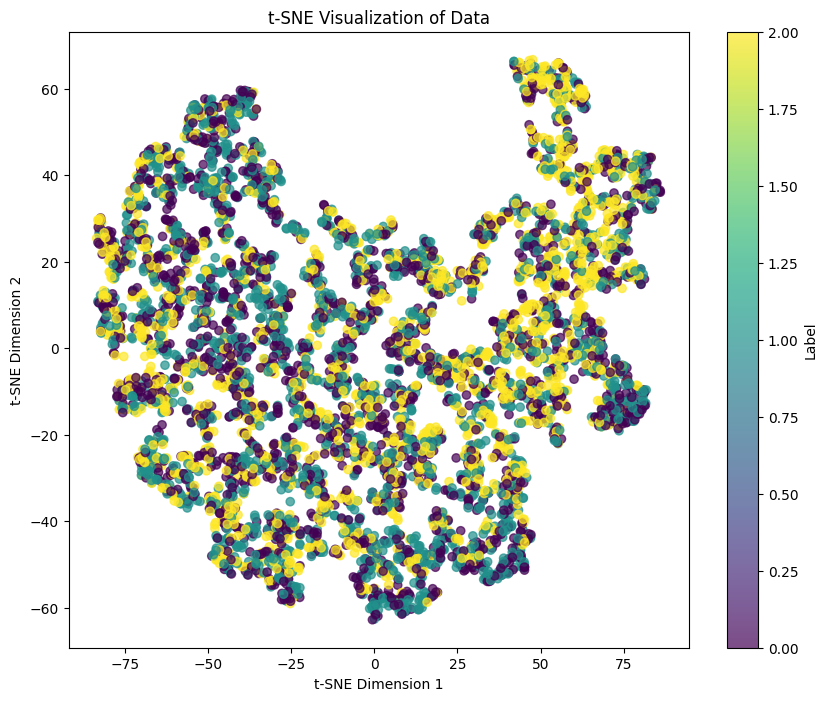

t-SNE Visualization for Pre-trained Model Dataset3:
Features shape: (6010, 512)
Labels shape: (6010,)


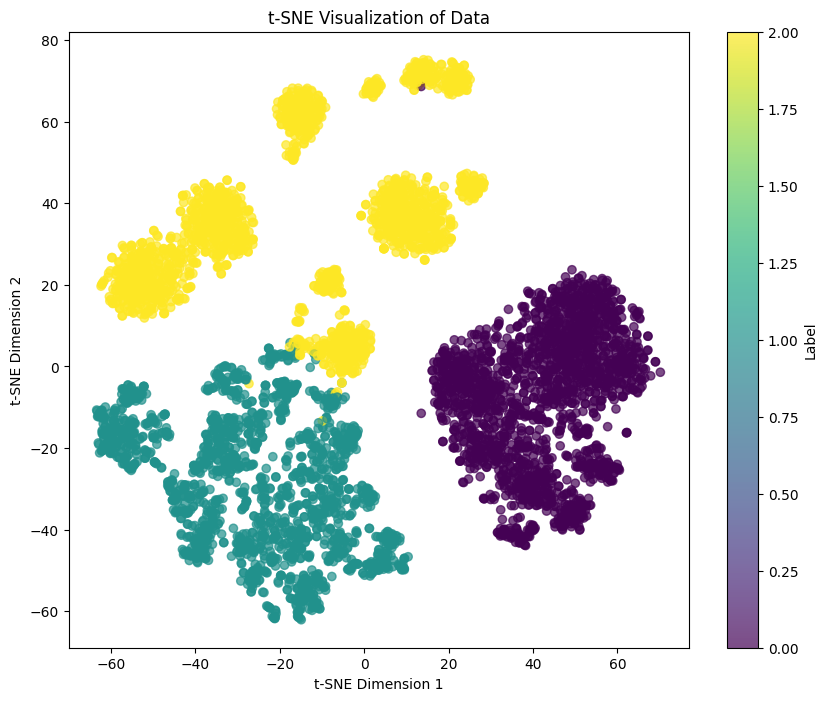

In [ ]:
# Make sure everything is in the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model.to(device)
pretrained_model.to(device)

# Put models into evaluate mode
my_model.eval()
pretrained_model.eval()

# Assuming `encoder_model` is the feature extractor model created from your trained model
features_my_model_dataset2, targets_my_model_dataset2 = collect_features_and_targets(all_loader_dataset2, my_model)
features_pretrained_model_dataset2, targets_pretrained_model_dataset2 = collect_features_and_targets(all_loader_dataset2, pretrained_model)
features_my_model_dataset3, targets_my_model_dataset3 = collect_features_and_targets(all_loader_dataset3, my_model)
features_pretrained_model_dataset3, targets_pretrained_model_dataset3 = collect_features_and_targets(all_loader_dataset3, pretrained_model)

# Apply t-SNE and visualize
print("t-SNE Visualization for Our Model Dataset 2:")
tsne_visualization(features_my_model_dataset2, targets_my_model_dataset2)

# Apply t-SNE and visualize
print("t-SNE Visualization for Pre-trained Model Dataset 2:")
tsne_visualization(features_pretrained_model_dataset2, targets_pretrained_model_dataset2)

# Apply t-SNE and visualize
print("t-SNE Visualization for Our Model Dataset 3:")
tsne_visualization(features_my_model_dataset3, targets_my_model_dataset3)

# Apply t-SNE and visualize
print("t-SNE Visualization for Pre-trained Model Dataset3:")
tsne_visualization(features_pretrained_model_dataset3, targets_pretrained_model_dataset3)

In [ ]:
# Extract features for Dataset 2
train_features_my_model_d2, train_labels_my_model_d2 = collect_features_and_targets(train_loader_dataset2, my_model)
cross_features_my_model_d2, cross_labels_my_model_d2 = collect_features_and_targets(cross_loader_dataset2, my_model)
test_features_my_model_d2, test_labels_my_model_d2 = collect_features_and_targets(test_loader_dataset2, my_model)

train_features_pretrained_d2, train_labels_pretrained_d2 = collect_features_and_targets(train_loader_dataset2, pretrained_model)
cross_features_pretrained_d2, cross_labels_pretrained_d2 = collect_features_and_targets(cross_loader_dataset2, pretrained_model)
test_features_pretrained_d2, test_labels_pretrained_d2 = collect_features_and_targets(test_loader_dataset2, pretrained_model)

# Extract features for Dataset 3
train_features_my_model_d3, train_labels_my_model_d3 = collect_features_and_targets(train_loader_dataset3, my_model)
cross_features_my_model_d3, cross_labels_my_model_d3 = collect_features_and_targets(cross_loader_dataset3, my_model)
test_features_my_model_d3, test_labels_my_model_d3 = collect_features_and_targets(test_loader_dataset3, my_model)

train_features_pretrained_d3, train_labels_pretrained_d3 = collect_features_and_targets(train_loader_dataset3, pretrained_model)
cross_features_pretrained_d3, cross_labels_pretrained_d3 = collect_features_and_targets(cross_loader_dataset3, pretrained_model)
test_features_pretrained_d3, test_labels_pretrained_d3 = collect_features_and_targets(test_loader_dataset3, pretrained_model)

In [ ]:
# Helper function to train, validate, and test SVM
def train_evaluate_svm(train_features, train_labels, cross_features, cross_labels, test_features, test_labels):
    # Grid search for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10],       # Regularization parameter
        'gamma': ['scale', 0.1, 0.01],  # Kernel coefficient
        'kernel': ['rbf']        # Using RBF kernel
    }
    grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, verbose=2)
    grid.fit(train_features, train_labels)

    # Best parameters from grid search
    print(f"Best parameters: {grid.best_params_}")

    # Validate on cross-validation set
    cross_predictions = grid.best_estimator_.predict(cross_features)
    print("Validation Performance:")
    print(classification_report(cross_labels, cross_predictions))

    # Test on test set
    test_predictions = grid.best_estimator_.predict(test_features)
    print("Test Performance:")
    print(classification_report(test_labels, test_predictions))

    return grid.best_estimator_

# Train SVMs for all four scenarios
print("Training SVM for My Model on Dataset 2...")
svm_my_model_d2 = train_evaluate_svm(train_features_my_model_d2, train_labels_my_model_d2,
                                     cross_features_my_model_d2, cross_labels_my_model_d2,
                                     test_features_my_model_d2, test_labels_my_model_d2)

print("\nTraining SVM for Pretrained Model on Dataset 2...")
svm_pretrained_d2 = train_evaluate_svm(train_features_pretrained_d2, train_labels_pretrained_d2,
                                       cross_features_pretrained_d2, cross_labels_pretrained_d2,
                                       test_features_pretrained_d2, test_labels_pretrained_d2)

print("\nTraining SVM for My Model on Dataset 3...")
svm_my_model_d3 = train_evaluate_svm(train_features_my_model_d3, train_labels_my_model_d3,
                                     cross_features_my_model_d3, cross_labels_my_model_d3,
                                     test_features_my_model_d3, test_labels_my_model_d3)

print("\nTraining SVM for Pretrained Model on Dataset 3...")
svm_pretrained_d3 = train_evaluate_svm(train_features_pretrained_d3, train_labels_pretrained_d3,
                                       cross_features_pretrained_d3, cross_labels_pretrained_d3,
                                       test_features_pretrained_d3, test_labels_pretrained_d3)

Training SVM for My Model on Dataset 2...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.6s
[CV] EN